In [115]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import os

1. 创建对应turn的文件夹，将变量名`turn`改为对应值  
    1. 将ID1000文件夹下C3、C4的bin文件复制到turn文件夹下  
        C3、C4的bin文件夹名与ARTIQ中`experiment label`一致.  
        例如turn_0.635_C3_xxx.bin、turn_0.635_C4_xxx.bin,其中xxx为采数启动时间  
    2. 将alice、bob的谈探测文件复制到turn文件夹下，文件名分别更正为Alice.txt、Bob.txt  
    
2. 修改`period`为对应周期，单位为[s]  

3. 修改`window_start`、`window_end`为荧光计数窗口，一般与ID1000的窗口保持一致，单位为[ps]

4. 修改`time_start`、`time_stop`为分析数据截至时间，单位为[s]

In [116]:
os.chdir(r'/media/zkd/Windows/Users/ION/Desktop/241209_393锁定/ref-fluore/224.368_27%')
os.listdir()

['0.125',
 '0.25',
 '0.25_1',
 '0.375',
 '0.5',
 '0.563',
 '0.746',
 'df_fit.png',
 'gamma_fit.png',
 'gamma_res_time.csv',
 'gamma_res_time_t.csv',
 'gamma_t.png',
 'pulse_count.csv']

In [117]:
turn='0.5'
period=500e-6
# 光计数窗口
window_start=80*1e3 # unit ps
window_end=112*1e3    # unit ps
# 分析数据截至时间
time_start=000 # unit seconds
time_stop=140000  # unit seconds
#脉冲
pulse_num=9
pulse_interval=5e6 # unit ps  

In [118]:
def read_id900_binary(path,channel):
    """
    从指定路径读取特定通道的二进制文件，并将其转换为 Pandas DataFrame。

    参数:
    path (str): 包含二进制文件的目录路径。
    channel (int): 要读取的通道号。

    返回:
    pandas.DataFrame: 包含二进制文件数据的 DataFrame,列名为 'time_satmp' 和 'start_index'。
    None: 如果未找到指定通道的二进制文件。
    """
    
    for file_name in os.listdir(path):
        if 'C{}'.format(channel) in file_name:
            pmt_array=np.fromfile('{}/{}'.format(path,file_name),dtype=np.uint64).reshape(-1,2)
            pmt_pd=pd.DataFrame(pmt_array,columns=['time_satmp','start_index'])
            return pmt_pd
    print('No channel {} bin file found'.format(channel))
    return None

pmt1_df=read_id900_binary(turn,3)
pmt2_df=read_id900_binary(turn,4)
## 时间限制
pmt1_df=pmt1_df[(pmt1_df['time_satmp']>=time_start/period)&(pmt1_df['time_satmp']<=time_stop/period)].copy()
pmt2_df=pmt2_df[(pmt2_df['time_satmp']>=time_start/period)&(pmt2_df['time_satmp']<=time_stop/period)].copy()

In [119]:
def window_index(df, start, end, pulse_num=1, pulse_interval=5e6):
    """
    生成一个布尔索引，用于筛选出指定数据框中时间戳在一系列时间窗口内的行。

    参数:
    df (pandas.DataFrame): 输入的数据框，包含 'time_satmp' 和 'start_index' 列。
    start (int or float): 第一个时间窗口的起始时间。
    end (int or float): 第一个时间窗口的结束时间。
    pulse_num (int, 可选): 脉冲的数量，默认为 1。
    pulse_interval (float, 可选): 相邻时间窗口之间的间隔[ps]，默认为 5us。

    返回:
    pandas.Series: 一个布尔索引，用于筛选出符合条件的行。
    """
    # 初始化一个布尔索引，所有元素初始化为 False
    _index = df['start_index'] < 0
    # 循环生成多个时间窗口的布尔索引
    for pulse_i in range(pulse_num):
        # 计算当前时间窗口的起始和结束时间
        _window_start = start + pulse_i * pulse_interval
        _window_end = end + pulse_i * pulse_interval
        # 生成当前时间窗口的布尔索引，并累加到总索引上
        _index += (df['time_satmp'] >= _window_start) & (df['time_satmp'] <= _window_end)
    return _index
pmt1_index=window_index(pmt1_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt2_index=window_index(pmt2_df,window_start,window_end,pulse_num=pulse_num,pulse_interval=pulse_interval)
pmt1_count=pmt1_df[pmt1_index]['start_index'].value_counts().sort_index(ascending=True)
pmt2_count=pmt2_df[pmt2_index]['start_index'].value_counts().sort_index(ascending=True)
PMT1_SUM=pmt1_count.sum()
PMT2_SUM=pmt2_count.sum()

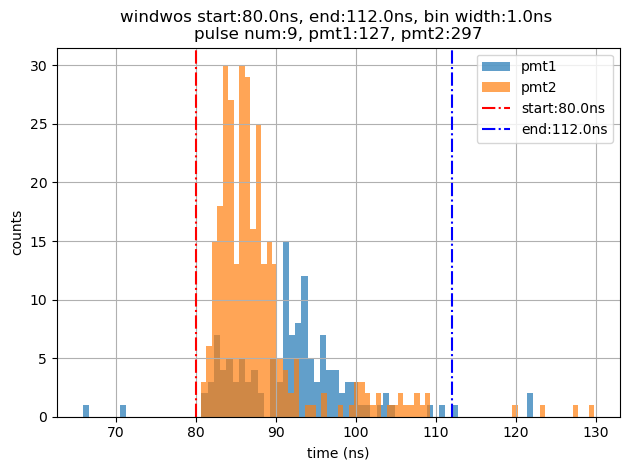

In [120]:
def hist_count(pmt1_df,pmt2_df,bin_t):
    """
    计数窗口内的光子数量，并绘制直方图展示不同探测器的光子计数随时间的分布。

    参数:
    pmt1_df (pandas.DataFrame): 第一个探测器的数据框，包含 'time_satmp' 列。
    pmt2_df (pandas.DataFrame): 第二个探测器的数据框，包含 'time_satmp' 列。
    bin_t (int): 直方图的时间间隔，单位为皮秒 (ps)。

    返回:
    无
    """
    hist_time_wid=20e3 # unit ps
    # bin_t=1000 #ps
    pmt1_hist_index=window_index(pmt1_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt2_hist_index=window_index(pmt2_df,window_start-hist_time_wid,window_end+hist_time_wid,pulse_num=pulse_num,pulse_interval=pulse_interval)
    pmt1_hist_ts=pmt1_df['time_satmp'][pmt1_hist_index]%pulse_interval
    pmt2_hist_ts=pmt2_df['time_satmp'][pmt2_hist_index]%pulse_interval
    info='windwos start:{:,.1f}ns, end:{:,.1f}ns, bin width:{:.1f}ns \n'.format(window_start/1e3,window_end/1e3, bin_t/1e3)
    info+='pulse num:{}, pmt1:{:,.0f}, pmt2:{:,.0f}'.format(pulse_num,PMT1_SUM,PMT2_SUM)
    bin_wid=int((window_end-window_start+2*hist_time_wid)//bin_t) # width of bin is 100ps 
    plt.hist(pmt1_hist_ts/1000,bins=bin_wid,label='pmt1',alpha=0.7)
    plt.hist(pmt2_hist_ts/1000,bins=bin_wid,label='pmt2',alpha=0.7)
    plt.xlabel('time (ns)')
    plt.ylabel('counts')
    plt.axvline(window_start/1000,color='r',linestyle='-.',label='start:{:.1f}ns'.format(window_start/1000))
    plt.axvline(window_end/1000,color='b',linestyle='-.',label='end:{:.1f}ns'.format(window_end/1000))
    plt.legend(loc=1)
    plt.title(info)
    plt.tight_layout()
    plt.grid()

hist_count(pmt1_df,pmt2_df,bin_t=1000)
# plt.savefig('./{}/histgram.png'.format(turn),dpi=300)
plt.show()

/tmp/ipykernel_16857/2761407803.py:11: RuntimeWarning: invalid value encountered in divide
  es_phase=(pmt1-pmt2)/(pmt1+pmt2)


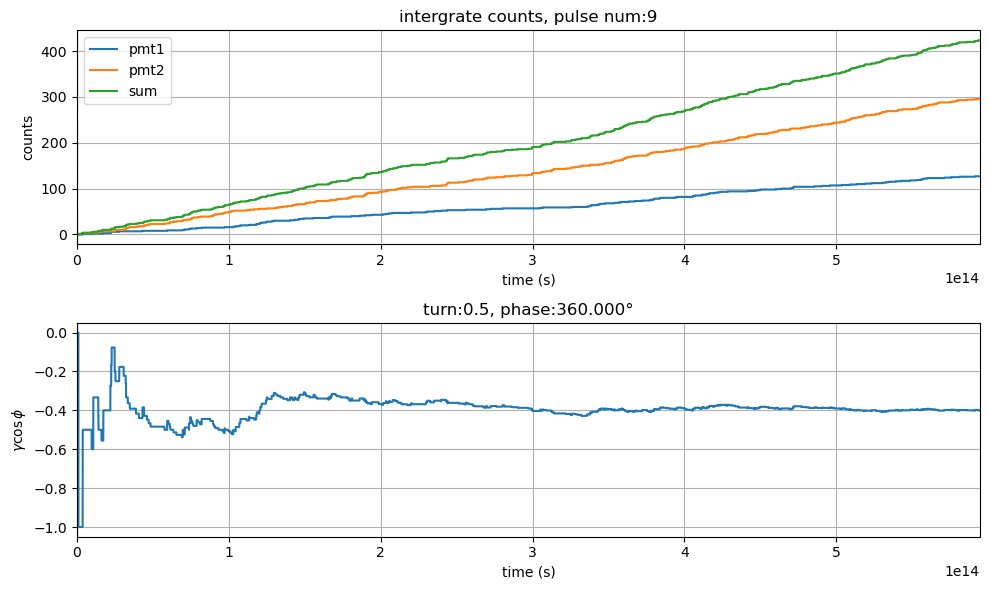

In [121]:
def plot_cumsum(pmt1_count,pmt2_count,period=500e6):
    "画出累加计数和相位估计"
    max_time=max(pmt1_count.index.max(),pmt2_count.index.max())
    time_index=np.arange(0,max_time+1,1)
    pmt1=np.zeros_like(time_index)
    pmt2=np.zeros_like(time_index)
    pmt1[pmt1_count.index]=pmt1_count.values
    pmt2[pmt2_count.index]=pmt2_count.values
    pmt1=pmt1.cumsum()
    pmt2=pmt2.cumsum()
    es_phase=(pmt1-pmt2)/(pmt1+pmt2)
    es_phase[es_phase!=es_phase]=0
    fig=plt.figure(figsize=(10,6))
    plt.subplot(211)
    plt.plot(time_index*period,pmt1,label='pmt1')
    plt.plot(time_index*period,pmt2,label='pmt2')
    plt.plot(time_index*period,pmt1+pmt2,label='sum')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.legend(loc=2)
    plt.title('intergrate counts, pulse num:{:.0f}'.format(pulse_num))
    plt.xlabel('time (s)')
    plt.ylabel('counts')
    plt.grid()
    plt.subplot(212)
    plt.plot(time_index*period,es_phase,label='gamma')
    plt.axvline(time_start,color='r',linestyle='-.')
    plt.axvline(time_stop,color='r',linestyle='-.')
    plt.xlim(0,max_time*period+10)
    plt.xlabel('time (s)')
    plt.ylabel(r'$\gamma \cos{\phi}$')
    plt.title('turn:{}, phase:{:.3f}°'.format(turn,float(turn.split('_')[0])*360*2))
    plt.grid()
    plt.tight_layout()
    return fig

plot_cumsum(pmt1_count,pmt2_count)
# plt.savefig('./{}/count_with_gamma_10pulse.png'.format(turn),dpi=300)
plt.show()

   time[us]  pmt1  pmt2
0       0.0    12    39
1       5.0    13    35
2      10.0    10    28
3      15.0    18    32
4      20.0    19    30
5      25.0    15    31
6      30.0    12    37
7      35.0    15    31
8      40.0    13    34
all pmt1:127, pmt2:297


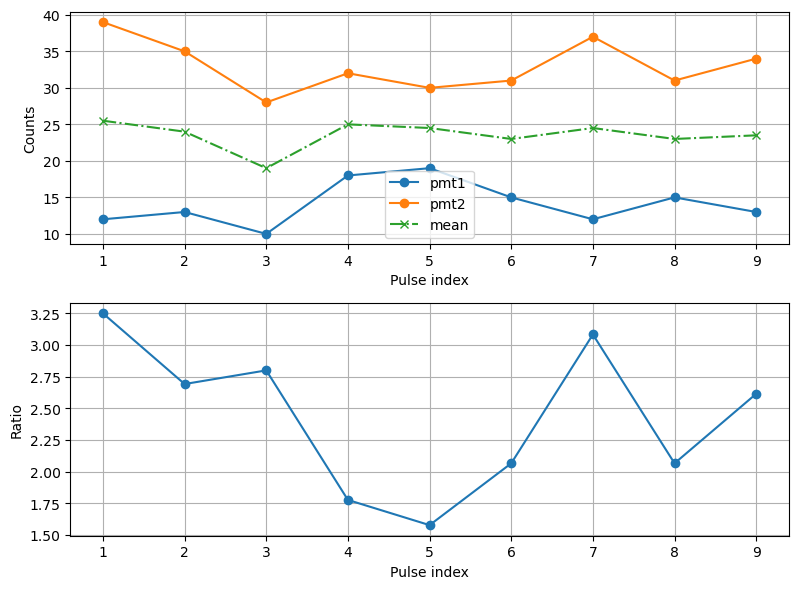

In [122]:
def pulse_count_df(pmt1_df,pmt2_df,pulse_interval=5e6,pulse_num=10,pulse_offset=0):
    """
    计算两个数据框（pmt1_df 和 pmt2_df）在一系列脉冲时间窗口内的脉冲计数，并将结果存储在一个 DataFrame 中。

    参数:
    pmt1_df (pandas.DataFrame): 第一个数据框，包含脉冲时间戳和起始索引。
    pmt2_df (pandas.DataFrame): 第二个数据框，包含脉冲时间戳和起始索引。
    pulse_interval (float, 可选): 脉冲间隔时间，默认为 5e6 ps。
    pulse_num (int, 可选): 要处理的脉冲数量，默认为 10。
    pulse_offset (int, 可选): 脉冲计数的起始偏移量，默认为 0。

    返回:  
    pandas.DataFrame: 包含每个脉冲的时间和两个数据框的脉冲计数的 DataFrame。
    """
    pulse_dict={'time[us]':[],'pmt1':[],'pmt2':[]}
    for pulse_i in range(pulse_offset,pulse_num):
        pulse_start=window_start+pulse_i*pulse_interval
        pulse_end=window_end+pulse_i*pulse_interval
        pmt1_pulse_index=window_index(pmt1_df,pulse_start,pulse_end)
        pmt2_pulse_index=window_index(pmt2_df,pulse_start,pulse_end)
        pmt1_pulse_count=pmt1_df[pmt1_pulse_index]['start_index'].value_counts().sort_index(ascending=True)
        pmt2_pulse_count=pmt2_df[pmt2_pulse_index]['start_index'].value_counts().sort_index(ascending=True)

        pulse_dict['time[us]'].append(pulse_i*pulse_interval*1e-6)
        pulse_dict['pmt1'].append(sum(pmt1_pulse_count))
        pulse_dict['pmt2'].append(sum(pmt2_pulse_count))
    return pd.DataFrame(pulse_dict)

pulse_df=pulse_count_df(pmt1_df,pmt2_df,pulse_num=pulse_num)
print(pulse_df)
print('all pmt1:{:,.0f}, pmt2:{:,.0f}'.format(np.sum(pulse_df['pmt1']),np.sum(pulse_df['pmt2'])))



def plot_pulse_counts(pulse_df):
    """
    绘制脉冲计数的可视化图表。

    参数:  
    pulse_df (pandas.DataFrame): 包含脉冲计数数据的 DataFrame，至少包含 'pmt1' 和 'pmt2' 列。

    返回:  
    matplotlib.figure.Figure: 包含绘制图表的 Figure 对象。
    """
    fig = plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(1+pulse_df.index,pulse_df['pmt1'],'o-',label='pmt1')
    plt.plot(1+pulse_df.index,pulse_df['pmt2'],'o-',label='pmt2')
    plt.plot(1+pulse_df.index,(pulse_df['pmt1']+pulse_df['pmt2'])/2,'x-.',label='mean')
    plt.xticks(1+pulse_df.index)
    plt.xlabel('Pulse index')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.subplot(2,1,2)
    if pulse_df['pmt1'].mean()>=pulse_df['pmt2'].mean():
        plt.plot(1+pulse_df.index,pulse_df['pmt1']/pulse_df['pmt2'],'o-')
    else:
        plt.plot(1+pulse_df.index,pulse_df['pmt2']/pulse_df['pmt1'],'o-')
    plt.xticks(1+pulse_df.index)
    plt.xlabel('Pulse index')
    plt.ylabel('Ratio')
    plt.grid()
    plt.tight_layout()
    return fig

plot_pulse_counts(pulse_df)
# plt.savefig('./{}/pulse_counts.png'.format(turn),dpi=300)
plt.show()

In [123]:
out_csv='gamma_res_time.csv'
try:
    with open(out_csv, 'r') as f:
        pass
except FileNotFoundError:
    # 文件不存在，写入标题
    with open(out_csv, 'w') as f:
        f.write('turn,state,start(ps),end(ps),pmt1,pmt2\n')

with open(out_csv,'a') as f:
    f.write('{a},origin,{t0:.0f},{t1:.0f},{pmt1:.0f},{pmt2:.0f}\n'.format(a=turn.split('_')[0],t0=window_start,t1=window_end,pmt1=PMT1_SUM,pmt2=PMT2_SUM))

# pulse_dict={'turn':[turn]*2,'pmt':[1,2],
#             0:[pmt1_list[0],pmt2_list[0]],1:[pmt1_list[1],pmt2_list[1]],2:[pmt1_list[2],pmt2_list[2]],3:[pmt1_list[3],pmt2_list[3]],4:[pmt1_list[4],pmt2_list[4]],
#             5:[pmt1_list[5],pmt2_list[5]],6:[pmt1_list[6],pmt2_list[6]],7:[pmt1_list[7],pmt2_list[7]],8:[pmt1_list[8],pmt2_list[8]],9:[pmt1_list[9],pmt2_list[9]]}

_=pulse_df.copy()
_.drop(columns=['time[us]'],inplace=True)
_['index']=_.index
out_csv='pulse_count.csv'
try:
    with open(out_csv, 'r') as f:
        pass
except FileNotFoundError:
    # 文件不存在，写入标题
    with open(out_csv, 'w') as f:
        f.write(','.join([str(i) for i in _.columns])+'\n')

with open(out_csv,'a') as f:
    f.write(','.join([str(i) for i in _.iloc[0]])+'\n')
    f.write(','.join([str(i) for i in _.iloc[1]])+'\n')